<a href="https://colab.research.google.com/github/filippomenegatti/Hate_Detection/blob/main/SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hate Speech Analysis

## Librerie

In [10]:
import os
import glob
import pandas as pd
from nltk.corpus import sentiwordnet as swn
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import lxml
import requests
import string
import re
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import *
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import linear_model, datasets, metrics
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix


import warnings
import numpy as np
from xgboost.sklearn import XGBClassifier
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Set Up e Funzioni

In [11]:
nltk_stopwords = stopwords.words('english')
nltk_stopwords.extend(['rt'])

In [12]:
def preprocessing(text, tokenize = False, stopwords = [], alphabetic=True, stem=False, lem=False, proc_type=None):

  '''
  This function to perform some preprocessing on the data:
    - The standard list of stopwords is empty and can be arbitrarily replaced.
    - It is possible to choose to remove or keep the non-alphabetical tokens.
    - it is possible to choose which kind of elaboration perform between nothing, lemmatization, and stemming.
    - ...
  '''
  
  #create tokens from text
  tokens = word_tokenize(text.lower())

  if alphabetic == True: # remove all tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
  else:
    tokens = tokens
 
  # remove all stopwords
  tokens = [word for word in tokens if not word in stopwords]

  # perform stemming or lemmatization and choose what type
  if stem == True:
    method = proc_type
    stem_tokens = [method.stem(token) for token in tokens]
    if tokenize == False:
      stem_tokens = ' '.join(stem_tokens)
      return stem_tokens
    else:
      return stem_tokens
  
  elif lem == True:
    method = proc_type
    lem_tokens = [method.lemmatize(token) for token in tokens]
    if tokenize == False:
      lem_tokens = ' '.join(lem_tokens)
      return lem_tokens
    else:
      return lem_tokens
  
  else:
    if tokenize == False:
      tokens = ' '.join(tokens)
      return tokens
    else:
      return tokens

In [13]:
def tfidf_vec(input, ngrams):
  vectorizer = TfidfVectorizer(
      ngram_range=ngrams,
      use_idf=True,
      lowercase = False,
      smooth_idf=False,
      decode_error='replace',
      max_features=10000,
      min_df=5,
      max_df=0.501
      )
  matrix = vectorizer.fit_transform(input).toarray()
  return matrix

## Caricamento del data set classificato

Download of labeled data.

In [14]:
labeled_data = pd.read_csv('https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv')
pd.set_option('display.max_colwidth', None)

labeled_data = labeled_data.drop(columns=['Unnamed: 0'])
display(labeled_data)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;
...,...,...,...,...,...,...
24778,3,0,2,1,1,"you's a muthaf***in lie &#8220;@LifeAsKing: @20_Pearls @corey_emanuel right! His TL is trash &#8230;. Now, mine? Bible scriptures and hymns&#8221;"
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, and drove me redneck crazy"
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I aint fuckin dis up again
24781,6,0,6,0,1,youu got wild bitches tellin you lies


In [17]:
labeled_data['clean_sents'] = labeled_data.apply(lambda row: preprocessing(row['tweet'], stopwords = ['rt'],
                                                                           stem = True, lem = False, proc_type = PorterStemmer(), tokenize = False), axis=1)
labeled_data.head(10)

,count,hate_speech,offensive_language,neither,class,tweet,clean_sents
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...,mayasolov as a woman you should complain about clean up your hous amp as a man you should alway take the trash out
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,boy dat cold tyga dwn bad for cuffin dat hoe in the place
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit,urkindofbrand dawg you ever fuck a bitch and she start to cri you be confus as shit
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,she look like a tranni
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;,shenikarobert the shit you hear about me might be true or it might be faker than the bitch who told it to ya
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just blows me..claim you so faithful and down for somebody but still fucking with hoes! &#128514;&#128514;&#128514;""",the shit just blow you so faith and down for somebodi but still fuck with hoe
6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up and HATE on another bitch .. I got too much shit going on!""",i can not just sit up and hate on anoth bitch i got too much shit go on
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of you big bitches coming for us skinny girls!!&#8221;,selfiequeenbri caus i tire of you big bitch come for us skinni girl
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; thats that """,amp you might not get ya bitch back amp that that
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Mariam""\n\nbitch",hobbi includ fight mariam bitch


In [18]:
labeled_data.drop(['count', 'hate_speech', 'offensive_language', 'neither', 'tweet'],axis=1,inplace=True)

In [ ]:
#use only if tokenize was set equal to false (default) in preprocessing function
labeled_data['tokens'] = labeled_data['clean_sents'].map(lambda x: word_tokenize(x))

labeled_data.head()

,class,clean_sents,tokens
0,2,mayasolovely a a woman you should complain about cleaning up your house amp a a man you should always take the trash out,"[mayasolovely, a, a, woman, you, should, complain, about, cleaning, up, your, house, amp, a, a, man, you, should, always, take, the, trash, out]"
1,1,boy dat cold tyga dwn bad for cuffin dat hoe in the place,"[boy, dat, cold, tyga, dwn, bad, for, cuffin, dat, hoe, in, the, place]"
2,1,urkindofbrand dawg you ever fuck a bitch and she start to cry you be confused a shit,"[urkindofbrand, dawg, you, ever, fuck, a, bitch, and, she, start, to, cry, you, be, confused, a, shit]"
3,1,she look like a tranny,"[she, look, like, a, tranny]"
4,1,shenikaroberts the shit you hear about me might be true or it might be faker than the bitch who told it to ya,"[shenikaroberts, the, shit, you, hear, about, me, might, be, true, or, it, might, be, faker, than, the, bitch, who, told, it, to, ya]"


In [ ]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in labeled_data['tokens']:
  tags = nltk.pos_tag(t)
  tag_list = [x[1] for x in tags]
  tag_str = " ".join(tag_list)
  tweet_tags.append(tag_str)

In [ ]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.501,
    )

pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()

In [ ]:
X = tfidf_vec(labeled_data.clean_sents, (1,3))
y = labeled_data['class']

In [ ]:
X_pos = np.concatenate([X, pos], axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pos, y, test_size=0.25, random_state=42)

## SMOTE Algorithm

In [ ]:
pd.value_counts(y_train)

1    14396
2     3122
0     1069
Name: class, dtype: int64

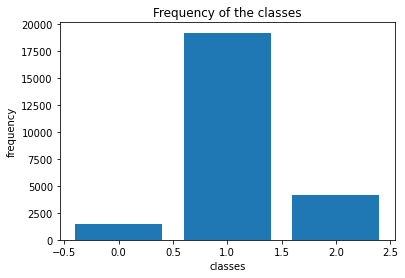

In [ ]:
plt.bar(np.arange(0, 3), np.bincount(y))
plt.title('Frequency of the classes')
plt.xlabel('classes')
plt.ylabel('frequency')
plt.show()

In [23]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [24]:
# transform the dataset
strategy = {1:8638}
undersample = RandomUnderSampler(sampling_strategy=strategy)
X_train_smote, y_train_smote = undersample.fit_resample(X_train, y_train)

In [ ]:
X_train_smote.shape

(12829, 13920)

In [ ]:
pd.value_counts(y_train_smote)

1    8638
2    3122
0    1069
Name: class, dtype: int64

## save/load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Sentiment_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Sentiment_data


In [ ]:
import pickle

In [ ]:
# with open('portstem_data.pickle', 'wb') as output:
#     pickle.dump(X_train_smote, output)
# with open('portstem_target.pickle', 'wb') as output:
#     pickle.dump(y_train_smote, output)
# with open('portstem_test.pickle', 'wb') as output:
#     pickle.dump(X_test, output)
# with open('portstem_test_target.pickle', 'wb') as output:
#     pickle.dump(y_test, output)

In [ ]:
#load data

with open('portstem_target.pickle', 'rb') as data:
    y_train = pickle.load(data)
with open('portstem_data.pickle', 'rb') as data:
    X_train = pickle.load(data)

with open('portstem_test_target.pickle', 'rb') as data:
    y_test = pickle.load(data)
with open('portstem_test.pickle', 'rb') as data:
    X_test = pickle.load(data)


## modelli base

### Random Forest

In [ ]:
classifier = RandomForestClassifier(n_estimators=300, random_state=42, verbose = 40, class_weight='balanced')
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 300


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


building tree 2 of 300


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


building tree 3 of 300


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s


building tree 4 of 300


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.6s remaining:    0.0s


building tree 5 of 300


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s remaining:    0.0s


building tree 6 of 300


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.3s remaining:    0.0s


building tree 7 of 300


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.4s remaining:    0.0s


building tree 8 of 300


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.3s remaining:    0.0s


building tree 9 of 300


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.6s remaining:    0.0s


building tree 10 of 300


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.5s remaining:    0.0s


building tree 11 of 300


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   10.4s remaining:    0.0s


building tree 12 of 300


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   11.4s remaining:    0.0s


building tree 13 of 300


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   12.3s remaining:    0.0s


building tree 14 of 300


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   13.4s remaining:    0.0s


building tree 15 of 300


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   14.3s remaining:    0.0s


building tree 16 of 300


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   15.4s remaining:    0.0s


building tree 17 of 300


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   16.3s remaining:    0.0s


building tree 18 of 300


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   17.3s remaining:    0.0s


building tree 19 of 300


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   18.3s remaining:    0.0s


building tree 20 of 300


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   19.3s remaining:    0.0s


building tree 21 of 300


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   20.3s remaining:    0.0s


building tree 22 of 300


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   21.1s remaining:    0.0s


building tree 23 of 300


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   22.0s remaining:    0.0s


building tree 24 of 300


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   22.8s remaining:    0.0s


building tree 25 of 300


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   23.8s remaining:    0.0s


building tree 26 of 300


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   25.0s remaining:    0.0s


building tree 27 of 300


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   26.0s remaining:    0.0s


building tree 28 of 300


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:   26.9s remaining:    0.0s


building tree 29 of 300


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:   27.9s remaining:    0.0s


building tree 30 of 300


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   28.8s remaining:    0.0s


building tree 31 of 300


[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:   29.7s remaining:    0.0s


building tree 32 of 300


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:   30.6s remaining:    0.0s


building tree 33 of 300


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   31.6s remaining:    0.0s


building tree 34 of 300


[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   32.6s remaining:    0.0s


building tree 35 of 300


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   33.7s remaining:    0.0s


building tree 36 of 300


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   34.6s remaining:    0.0s


building tree 37 of 300


[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:   35.5s remaining:    0.0s


building tree 38 of 300


[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   36.7s remaining:    0.0s


building tree 39 of 300


[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   37.9s remaining:    0.0s


building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  4.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elaps

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print('The Accuracy Score is:',accuracy_score(y_test, y_pred))
print('The Weighted F1 Score is:',f1_score(y_test, y_pred, average='weighted'))

[[  46  269   46]
 [  58 4594  142]
 [  10  224  807]]
              precision    recall  f1-score   support

           0       0.40      0.13      0.19       361
           1       0.90      0.96      0.93      4794
           2       0.81      0.78      0.79      1041

    accuracy                           0.88      6196
   macro avg       0.71      0.62      0.64      6196
weighted avg       0.86      0.88      0.86      6196

The Accuracy Score is: 0.8791155584247902
The Weighted F1 Score is: 0.8639327838263776


In [ ]:
import tensorflow as tf
from sklearn import linear_model, datasets, metrics

In [ ]:
conf_matrix=tf.math.confusion_matrix(y_test,y_pred,num_classes=3).numpy()
con_mat_norm = np.around(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)
print(con_mat_norm)
plt.matshow(con_mat_norm,cmap=plt.cm.hot)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_test,y_scores, classNames):
    # y_test=np.argmax(y_test, axis=1)
    # y_scores=np.argmax(y_scores, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y]/np.sum(cm[x,:])

    plt.figure(figsize=(5,5))
    sns.set(font_scale=1.0) # for label size
    df = sns.heatmap(con, annot=True,fmt='.2', xticklabels= classNames , yticklabels= classNames)
    df.figure.savefig("image2.png")

classNames = ['0', '1', '2'] 
plot_confusion_matrix(y_test,y_pred, classNames) 

### Naive Bayes

In [ ]:
### Naive Bayes
alpha = np.linspace(1, 100, 100)
nb_grid = GridSearchCV(estimator= MultinomialNB(),
                       param_grid=dict(
                           alpha = alpha),
                  scoring="f1_weighted",
                  cv = 5)
nb_grid.fit(X_train_smote, y_train_smote)

nb_grid_best_hyperparameter = nb_grid.best_estimator_.alpha

nb_best_hyper = MultinomialNB(alpha = nb_grid_best_hyperparameter)
nb_best_hyper.fit(X_train, y_train)

np_y_preds = nb_best_hyper.predict(X_test)

In [ ]:
print('The best score is:',nb_grid.best_score_,'\n')
print('The best hyperparameter found is:',nb_grid_best_hyperparameter,'\n')
print('The classification report is: \n',classification_report(y_test, np_y_preds))
print('The Weighted F1 Score is:',f1_score(y_test, np_y_preds, average='weighted'))

The best score is: 0.8318534017338696 

The best hyperparameter found is: 11.0 

The classification report is: 
               precision    recall  f1-score   support

           0       0.34      0.35      0.34       361
           1       0.93      0.89      0.91      4794
           2       0.71      0.86      0.78      1041

    accuracy                           0.85      6196
   macro avg       0.66      0.70      0.68      6196
weighted avg       0.86      0.85      0.85      6196

The Weighted F1 Score is: 0.854715940976575


### Support Vector Machine

In [ ]:
svm = SVC()
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[  41  137  183]
 [ 132 3346 1316]
 [  25  171  845]]
              precision    recall  f1-score   support

           0       0.21      0.11      0.15       361
           1       0.92      0.70      0.79      4794
           2       0.36      0.81      0.50      1041

    accuracy                           0.68      6196
   macro avg       0.49      0.54      0.48      6196
weighted avg       0.78      0.68      0.71      6196

0.6830213040671401


In [ ]:
param_grid = { 'C':[0.1,1,100],
              'kernel':['rbf','poly','sigmoid','linear'],
              'degree':[1,2,3],
              'gamma': [1, 0.1, 0.01, 0.001]}

In [ ]:
grid = GridSearchCV(SVC(),
                    param_grid,
                    refit=True,
                    cv = 5,
                    verbose=40,
                    n_jobs=-1)

grid.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
print(grid.best_estimator_)

In [ ]:
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))  #Output

### XGBoost

eXtreme Gradient Boosting - XGBoost è un’implementazione open source popolare ed efficiente dell’algoritmo Gradient Boosting.

Si prefigge di minimizzare una funzione obiettivo regolarizzata (L1 e L2) che combina una funzione di perdita (basata sulla differenza tra i valori osservati e previsti) e un termine di penalità per la complessità del modello (in altre parole, la funzione dell’albero di regressione, il pruning).

L’addestramento procede in modo iterativo, aggiungendo nuovi alberi che predicono i residui, i quali vengono poi combinati con gli alberi precedenti di un fattore eta per eseguire la previsione finale.

https://www.lorenzogovoni.com/cose-lalgoritmo-xgboost/

In [ ]:
#tuning parameters - max_depth, min_child_weight, gamma, subsample, colsample_bytree, reg_alpha

###General Approach for Parameter Tuning
We will use an approach similar to that of GBM here. The various steps to be performed are:

- **Choose a relatively high learning rate.**  Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
- **Tune tree-specific parameters** ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
- **Tune regularization parameters** (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.
- **Lower the learning rate** and decide the optimal parameters .

Reference (https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

In [ ]:
import xgboost as xgb

In [ ]:
def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)#, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')
        
    #Predict training set:
    y_predictions = alg.predict(X_test)
    y_predprob = alg.predict_proba(X_test)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_test.values, y_predictions))
    print("F1 Score : %.4g" % metrics.f1_score(y_test.values, y_predictions, average= 'macro'))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, y_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 num_class = 3,
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1, X_train, y_train)

In [ ]:
#1 - Tune max_depth and min_child_weight
param_test1 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
# model fit 1 con i best parameters presi dal tuning sopra
modelfit(gsearch1.best_estimator_, X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
#2 - Tune gamma 
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
#3 - Tuning Regularization Parameters
param_test6 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train, y_train)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_


In [ ]:
#applicare i valori dei parametri, selezionati dal tuning, e valutare l'algoritmo ()
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,         #da cambiare
 min_child_weight=6,  #da cambiare
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,     #da cambiare
 objective= 'binary:logistic',
 num_class=3,
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, X_train, y_train)

In [ ]:
# da capire che è e come fare il tuning - eXtreme Gradient Boosting 
xgbr = XGBClassifier()
xgbr.fit(X_train, y_train)
 
y_pred = xgbr.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

## Sparse Tensor Classifier

In [ ]:
!pip install stc

In [ ]:
from stc import SparseTensorClassifier

In [26]:
models = {
    'Multinomial NV': MultinomialNB(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost' : XGBClassifier()
}

In [27]:
labeled_data

,class,clean_sents
0,2,mayasolov as a woman you should complain about clean up your hous amp as a man you should alway take the trash out
1,1,boy dat cold tyga dwn bad for cuffin dat hoe in the place
2,1,urkindofbrand dawg you ever fuck a bitch and she start to cri you be confus as shit
3,1,she look like a tranni
4,1,shenikarobert the shit you hear about me might be true or it might be faker than the bitch who told it to ya
...,...,...
24778,1,you a lie lifeask right hi tl is trash now mine bibl scriptur and hymn
24779,2,you gone and broke the wrong heart babi and drove me redneck crazi
24780,1,young buck wan na eat dat nigguh like i aint fuckin di up again
24781,1,youu got wild bitch tellin you lie


In [28]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(labeled_data, test_size=0.25, random_state = 42)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
print(train.shape)
print(test.shape)

(18587, 2)
(6196, 2)


In [41]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=nltk.word_tokenize)
X_train = vectorizer.fit_transform(train.clean_sents)
X_test = vectorizer.transform(test.clean_sents)
y_train, y_test = train['class'], test['class']


In [43]:
# transform the dataset
strategy = {1:8638}
undersample = RandomUnderSampler(sampling_strategy=strategy)
X_train_smote, y_train_smote = undersample.fit_resample(X_train, y_train)

In [45]:
for model_name, model in models.items():
    print("Training: {}".format(model_name))
    models[model_name].fit(X_train_smote, y_train_smote)

Training: Multinomial NV
Training: Random Forest
Training: XGBoost


In [46]:
predictions = {}
for model_name, model in models.items():
    print("Predicting: {}".format(model_name))
    predictions[model_name] = model.predict(X_test)

Predicting: Multinomial NV
Predicting: Random Forest
Predicting: XGBoost


In [47]:
json_train, json_test = [], []
for i, doc in list(enumerate(train.clean_sents)):
    json_train.append({'words': nltk.word_tokenize(doc), 'target': [train['class'][i]]})
for i, doc in list(enumerate(test.clean_sents)):
    json_test.append({'words': nltk.word_tokenize(doc)})

In [48]:
STC = SparseTensorClassifier(features=['words'], targets=['target'])
STC.fit(json_train)

Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/pool/base.py", line 739, in _finalize_fairy
    fairy._reset(pool)
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/pool/base.py", line 988, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/engine/default.py", line 669, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140236766631808 and this is thread id 140236106172160.
Exception closing connection <sqlite3.Connection object at 0x7f8b1c31a570>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/pool/base.py", line 739, in _finalize_fairy
    fairy._reset(pool)
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/pool/base.py", line 988, in _reset
    pool._dialect.do_rol

In [54]:
expl_words = STC.explain()

In [55]:
#Top 10 per target
expl_words['features'] = expl_words['features'].map(lambda x: x.replace("words: ", ""))
hate = expl_words[expl_words.index == "0"]
#hate['features'] = hate['features'].map(lambda x: x.replace("words: ", ""))
hate.head(10)

,features,score
target,,
0,faggot,0.130740
0,nigger,0.095456
0,fag,0.088165
0,bitch,0.065937
0,fuck,0.048236
0,nigga,0.046090
0,wetback,0.043421
0,queer,0.042505
0,white,0.041728


In [56]:
offensive = expl_words[expl_words.index == "1"]
offensive.head(10)

,features,score
target,,
1,bitch,0.126100
1,hoe,0.058992
1,pussi,0.057364
1,fuck,0.037308
1,nigga,0.034340
1,faggot,0.032890
1,shit,0.027019
1,fag,0.026499
1,ass,0.025305


In [57]:
neutral = expl_words[expl_words.index == "2"]
neutral.head(10)

,features,score
target,,
2,bird,0.081795
2,yanke,0.073113
2,charli,0.072317
2,oreo,0.052884
2,yellow,0.051755
2,browni,0.050377
2,trash,0.038479
2,mock,0.033176
2,sole,0.031738


In [58]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

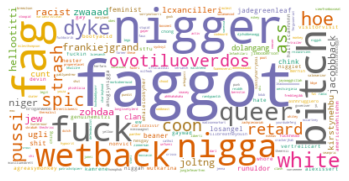

In [59]:
#Word Cloud
text_dict= dict(hate.values)

# create the WordCloud object
wordcloud = WordCloud(background_color='white', colormap= "Dark2")

# generate the word cloud
wordcloud.generate_from_frequencies(text_dict)

#plot
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

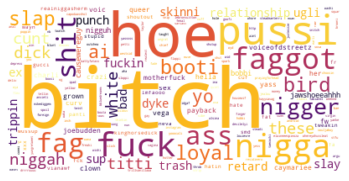

In [60]:
text_dict= dict(offensive.values)

# create the WordCloud object
wordcloud = WordCloud(background_color='white', colormap= "inferno")

# generate the word cloud
wordcloud.generate_from_frequencies(text_dict)

#plot
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

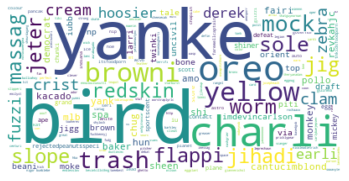

In [61]:
text_dict= dict(neutral.values)

# create the WordCloud object
wordcloud = WordCloud(background_color='white')

# generate the word cloud
wordcloud.generate_from_frequencies(text_dict)

#plot
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [49]:
labels, _, _ = STC.predict(json_test, explain=False)
labels = labels.fillna(0)
predictions['Sparse Tensor Classifier'] = labels.target.values.astype(int)

In [50]:
import sklearn.metrics as mtr

In [51]:
E = []
for estimator, y_pred in predictions.items():
    report = mtr.classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    E.append({
        'Model': estimator, 'Accuracy': report['accuracy'],
        'Avg Precision (macro)': report['macro avg']['precision'],
        'Avg Recall (macro)': report['macro avg']['recall'],
        'Avg F1-score (macro)': report['macro avg']['f1-score'],
        'Avg Precision (weighted)': report['weighted avg']['precision'],
        'Avg Recall (weighted)': report['weighted avg']['recall'],
        'Avg F1-score (weighted)': report['weighted avg']['f1-score']
    })
E = pd.DataFrame(E).set_index('Model', inplace=False)

In [52]:
E #recall = TP / (TP + FN) ; precision = TP / (TP + FP) ; Cerce definizione avg recall weighted vs macro

,Accuracy,Avg Precision (macro),Avg Recall (macro),Avg F1-score (macro),Avg Precision (weighted),Avg Recall (weighted),Avg F1-score (weighted)
Model,,,,,,,
Multinomial NV,0.785345,0.573864,0.357391,0.337882,0.763715,0.785345,0.702226
Random Forest,0.857005,0.735367,0.553267,0.594405,0.839717,0.857005,0.834173
XGBoost,0.883473,0.710304,0.739020,0.716319,0.890161,0.883473,0.882882
Sparse Tensor Classifier,0.853938,0.693324,0.790277,0.720951,0.897947,0.853938,0.870525


In [53]:
report

{'0': {'f1-score': 0.40819964349376114,
  'precision': 0.3009198423127464,
  'recall': 0.6343490304709142,
  'support': 361},
 '1': {'f1-score': 0.9112231477422182,
  'precision': 0.9600461893764434,
  'recall': 0.8671255736337088,
  'support': 4794},
 '2': {'f1-score': 0.8434296365330849,
  'precision': 0.8190045248868778,
  'recall': 0.8693563880883766,
  'support': 1041},
 'accuracy': 0.8539380245319561,
 'macro avg': {'f1-score': 0.7209508092563547,
  'precision': 0.6933235188586891,
  'recall': 0.7902769973976665,
  'support': 6196},
 'weighted avg': {'f1-score': 0.8705251925772084,
  'precision': 0.8979466115805054,
  'recall': 0.8539380245319561,
  'support': 6196}}

[Link dell'articolo](https://towardsdatascience.com/an-automatic-hyperparameter-optimization-on-a-twitter-sentiment-analysis-problem-6d5dc732f500)

## Analysis and tuning

In [ ]:
!pip install optuna

In [ ]:
import optuna
from optuna.trial import TrialState

### Random Forest

In [ ]:
def objective(trial):
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
  bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
  max_depth = trial.suggest_int('max_depth', 20, 35)
  n_estimators =  trial.suggest_int('n_estimators', 50, 300, step=50)
    
  clf = RandomForestClassifier(bootstrap = bootstrap, criterion = criterion,
                                 max_depth = max_depth,
                                 n_estimators = n_estimators,n_jobs=-1, class_weight='balanced')
  score = cross_val_score(clf, X_train, y_train, cv=5, scoring="f1_weighted").mean()
  return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2021-11-15 09:08:03,733] A new study created in memory with name: no-name-ba37ee39-8b16-4b90-9a17-3ac3cea60794
[I 2021-11-15 09:11:09,245] Trial 0 finished with value: 0.842602919264303 and parameters: {'criterion': 'gini', 'bootstrap': 'False', 'max_depth': 29, 'n_estimators': 50}. Best is trial 0 with value: 0.842602919264303.
[I 2021-11-15 09:13:46,066] Trial 1 finished with value: 0.837609777330866 and parameters: {'criterion': 'gini', 'bootstrap': 'False', 'max_depth': 24, 'n_estimators': 50}. Best is trial 0 with value: 0.842602919264303.
[I 2021-11-15 09:25:17,959] Trial 2 finished with value: 0.8475257202670534 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 29, 'n_estimators': 200}. Best is trial 2 with value: 0.8475257202670534.
[I 2021-11-15 09:28:06,139] Trial 3 finished with value: 0.8379166559522764 and parameters: {'criterion': 'gini', 'bootstrap': 'True', 'max_depth': 26, 'n_estimators': 50}. Best is trial 2 with value: 0.8475257202670534.
[I 

In [ ]:
trial = study.best_trial
print('F1 Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

F1 Score: 0.8543300169350418
Best hyperparameters: {'criterion': 'entropy', 'bootstrap': 'False', 'max_depth': 22, 'n_estimators': 300}


              precision    recall  f1-score   support

           0       0.37      0.46      0.41       361
           1       0.96      0.87      0.91      4794
           2       0.69      0.93      0.79      1041

    accuracy                           0.86      6196
   macro avg       0.67      0.75      0.70      6196
weighted avg       0.88      0.86      0.86      6196

The Accuracy Score is: 0.856358941252421
The Weighted F1 Score is: 0.8633442030425632


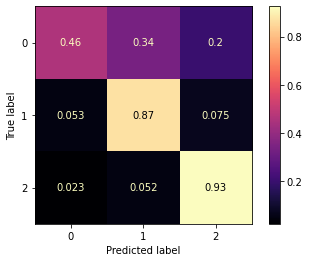

In [ ]:
# optimised_rf = RandomForestClassifier(bootstrap = study.best_params['bootstrap'], criterion = study.best_params['criterion'],
#                                     max_depth = study.best_params['max_depth'], n_estimators = study.best_params['n_estimators'], n_jobs=-1, class_weight='balanced')

# optimised_rf = RandomForestClassifier(bootstrap = False, criterion = 'entropy',
#                                      max_depth = 25,n_estimators = 250,n_jobs=-1,class_weight='balanced')

optimised_rf = RandomForestClassifier(bootstrap = False, criterion = 'entropy',
                                     max_depth = 22,n_estimators = 300,n_jobs=-1,class_weight='balanced')


optimised_rf.fit(X_train ,y_train)

y_pred = optimised_rf.predict(X_test)

#print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print('The Accuracy Score is:',accuracy_score(y_test, y_pred))
print('The Weighted F1 Score is:',f1_score(y_test, y_pred, average='weighted'))

# Confusion Matrix
plot_confusion_matrix(optimised_rf, X_test, y_test, normalize= 'true', cmap= 'magma')  
plt.show()

### Multinomial Naive Bayes

In [ ]:
def objective(trial):
  alpha = trial.suggest_float('alpha', 0.01, 10, log=True)

  clf = MultinomialNB(alpha=alpha)

  score = cross_val_score(clf, X_train, y_train, cv=5, scoring="f1_weighted").mean()
  return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [ ]:
trial = study.best_trial
print('F1 - Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params)) #(lemmatization)

F1 - Score: 0.7474992758770906
Best hyperparameters: {'alpha': 0.010514115238530885}


              precision    recall  f1-score   support

           0       0.31      0.16      0.21       361
           1       0.86      0.92      0.89      4794
           2       0.66      0.56      0.60      1041

    accuracy                           0.82      6196
   macro avg       0.61      0.55      0.57      6196
weighted avg       0.80      0.82      0.80      6196

The Accuracy Score is: 0.8173014848289218
The Weighted F1 Score is: 0.8044047517710032


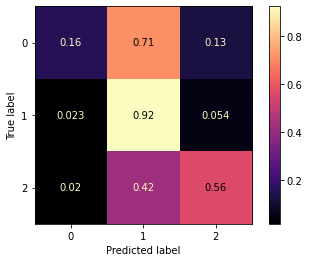

In [ ]:
#optimised_mnb = MultinomialNB(alpha=study.best_params['alpha'])  #0.010160965365387773 (porter)

optimised_mnb = MultinomialNB(alpha = 0.010514115238530885)

optimised_mnb.fit(X_train, y_train)

y_pred = optimised_mnb.predict(X_test)

#print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print('The Accuracy Score is:',accuracy_score(y_test, y_pred))  #0.8043899289864429 (porter)
print('The Weighted F1 Score is:',f1_score(y_test, y_pred, average='weighted'))  #0.8041959620864586 (porter)

# Confusion matrix
plot_confusion_matrix(optimised_mnb, X_test, y_test, normalize= 'true', cmap= 'magma')  
plt.show()

In [ ]:
plot_confusion_matrix(optimised_mnb, X_test, y_test, normalize= 'true', cmap= 'magma')  
plt.show()

### XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# optuna's objective function
def objective(trial):
  learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5, log=True)
  max_depth = trial.suggest_int("max_depth", 2, 10,step=2, log=False)
  n_estimators = trial.suggest_int("n_estimators", 100, 300,step=100, log=False)

  model = XGBClassifier(objective= 'multi:softmax',
                        learning_rate = learning_rate,
                        n_estimators = n_estimators,
                        max_depth = max_depth,
                        seed=42)

  # Handle pruning based on the intermediate value.
  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1_weighted").mean()
  return score

In [ ]:
# study to maximize the accuracy metric
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

[I 2021-11-15 21:12:14,364] A new study created in memory with name: no-name-94f40e70-fcdb-4add-8801-dc39212ae8c5
[I 2021-11-15 23:43:21,509] Trial 0 finished with value: 0.8695566792024669 and parameters: {'learning_rate': 0.06645389629080399, 'max_depth': 2, 'n_estimators': 300}. Best is trial 0 with value: 0.8695566792024669.
[I 2021-11-16 01:10:32,599] Trial 1 finished with value: 0.874460268162238 and parameters: {'learning_rate': 0.2473847108709958, 'max_depth': 4, 'n_estimators': 100}. Best is trial 1 with value: 0.874460268162238.


In [ ]:
trial = study.best_trial
print('F1 Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

              precision    recall  f1-score   support

           0       0.46      0.35      0.40       361
           1       0.96      0.92      0.94      4794
           2       0.76      0.96      0.85      1041

    accuracy                           0.89      6196
   macro avg       0.72      0.74      0.73      6196
weighted avg       0.89      0.89      0.89      6196

The Accuracy Score is: 0.8918657198192382
The Weighted F1 Score is: 0.8902955169018264


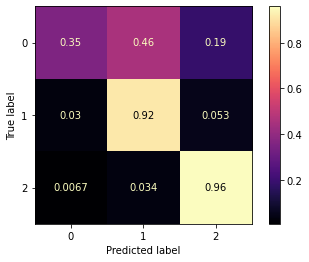

In [ ]:
#lemmatization

optimised_xgb = XGBClassifier(objective= 'multi:softmax',
                        learning_rate = 0.2473847108709958,
                        n_estimators = 100,
                        max_depth = 4,
                        seed=42)

optimised_xgb.fit(X_train, y_train)

y_pred = optimised_xgb.predict(X_test)

#print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print('The Accuracy Score is:',accuracy_score(y_test, y_pred))  #0.8863783085861846 (porter)
print('The Weighted F1 Score is:',f1_score(y_test, y_pred, average='weighted'))  #0.8841798992863336 (porter)

# Confusion Matrix
plot_confusion_matrix(optimised_xgb, X_test, y_test, normalize= 'true', cmap= 'magma')  
plt.show()

              precision    recall  f1-score   support

           0       0.47      0.32      0.38       361
           1       0.96      0.91      0.93      4794
           2       0.73      0.97      0.83      1041

    accuracy                           0.89      6196
   macro avg       0.72      0.73      0.72      6196
weighted avg       0.89      0.89      0.88      6196

The Accuracy Score is: 0.8863783085861846
The Weighted F1 Score is: 0.8841798992863336


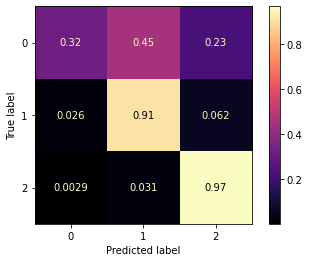

In [ ]:
#porter

optimised_xgb = XGBClassifier(objective= 'multi:softmax',
                        learning_rate = 0.0365241029983789,
                        n_estimators = 100,
                        max_depth = 8,
                        seed=42)

optimised_xgb.fit(X_train, y_train)

y_pred = optimised_xgb.predict(X_test)

#print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print('The Accuracy Score is:',accuracy_score(y_test, y_pred))  #0.8863783085861846 (porter)
print('The Weighted F1 Score is:',f1_score(y_test, y_pred, average='weighted'))  #0.8841798992863336 (porter)

# Confusion Matrix
plot_confusion_matrix(optimised_xgb, X_test, y_test, normalize= 'true', cmap= 'magma')  
plt.show()